In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
import math
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [2]:
from pymongo import MongoClient # Install for using this lib.
import subprocess

In [3]:
dbname = 'test'
collection_name1 = 'reviews'

path = "/Users/groverprince/Documents/msan/msan_intermission/project/"

input_file_name1 = path+"review.json"


In [4]:
reviews_rdd =spark.read.json(path + 'review.json', multiLine=True)


In [5]:
reviews_df = sqlContext.read.json(path + 'review.json')

In [6]:
reviews_df.show(2)

+--------------------+----------+--------------------+-----+--------------------+--------------------+
|         business_id|      date|           review_id|stars|                text|             user_id|
+--------------------+----------+--------------------+-----+--------------------+--------------------+
|jQsNFOzDpxPmOurSW...|2015-03-26|i5UwUPlQFPLcE8p2g...|    4|For being fairly ...|WZXp9-V2dqRRJqhGg...|
|jQsNFOzDpxPmOurSW...|2012-12-30|EyQyvTTg2jX4or9bB...|    5|I decided to try ...|XylT12exfdLiI_3uD...|
+--------------------+----------+--------------------+-----+--------------------+--------------------+
only showing top 2 rows



In [7]:
reviews_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [8]:
reviews_df.count()

1269069

## Star histogram

In [46]:
df_rating_histogram = reviews_df.select('stars').rdd.flatMap(lambda x: x).\
                            map(lambda x: (x,1)).\
                            reduceByKey(lambda x,y : x+y )

In [49]:
df_rating_hist_collect = df_rating_histogram.collect()

In [48]:
import numpy as np
import matplotlib.pyplot as plt

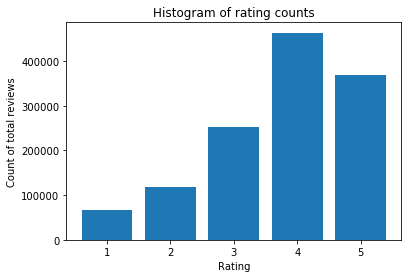

In [53]:
# save the stars and counts
star = zip(*df_rating_hist_collect)[0]
count = zip(*df_rating_hist_collect)[1]
x_pos = np.arange(len(df_rating_hist_collect)) 
  
plt.bar(x_pos, count,align='center')
plt.xticks(x_pos, star) 
plt.title('Histogram of rating counts')
plt.xlabel('Rating')
plt.ylabel('Count of total reviews')
plt.show()

## NB

In [9]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, IndexToString, NGram
from pyspark.ml import Pipeline
from pyspark.sql import Row

In [10]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

### with bigrams

In [30]:
train_data, test_data = reviews_df.randomSplit([0.8, 0.2])

categoryIndexer = StringIndexer(inputCol="stars", outputCol="label")

tokenizer = Tokenizer(inputCol="text", outputCol="words")

ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

#ngram.transform(reviews_filter).show()

hashingTF = HashingTF(inputCol="ngrams", outputCol="features", numFeatures=100000)

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

#categoryConverter = IndexToString(inputCol="prediction", outputCol="predCategory", labels=categoryIndexer.labels)

pipeline = Pipeline(stages=[categoryIndexer, tokenizer,ngram, hashingTF, nb])

model = pipeline.fit(train_data)
pr = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
metric = evaluator.evaluate(pr)

In [31]:
print "F1 metric = %g" % metric

F1 metric = 0.555057


### without bigrams

In [79]:
train_data, test_data = reviews_df.randomSplit([0.8, 0.2])

categoryIndexer = StringIndexer(inputCol="stars", outputCol="label")

tokenizer = Tokenizer(inputCol="text", outputCol="words")

#ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

#ngram.transform(reviews_filter).show()

hashingTF = HashingTF(inputCol="words", outputCol="features", numFeatures=100000)

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

#categoryConverter = IndexToString(inputCol="prediction", outputCol="predCategory", labels=categoryIndexer.labels)

pipeline = Pipeline(stages=[categoryIndexer, tokenizer, hashingTF, nb])

model = pipeline.fit(train_data)
pr = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
metric = evaluator.evaluate(pr)

In [80]:
print "F1 metric = %g" % metric

F1 metric = 0.543673


### Stemming

In [12]:
from stemming.porter2 import stem

In [126]:
documents = [reviews_df.select('text').rdd.take(2)[1][0]]
documents = [[stem(word) for word in sentence.split(" ")] for sentence in documents]
documents = [" ".join(sentence) for sentence in documents]

In [136]:
documents

[u"I decid to tri it out, I'm celiac and therefor can onli eat gluten free...\nThey have an easi to understand GF Menu with anyth you can possibl want.\n\nI place my order onlin and pick the exact pickup time. I cam and my food was readi for me. Drive home the smell in my car was so good I could bare wait to get home and tri it - true umami!\n\nI got home and dug into the delici spici chicken and rice with sugar snapi and carrots. It was superb! For $9 I will definit tri this again! I did see a huge line at the store, so tri do an onlin order and pickup forsure!\n\np.s. they even includ GF soy sauce!"]

In [130]:
[reviews_df.select('text').rdd.take(2)[1][0]]

[u"I decided to try it out, I'm celiac and therefore can only eat gluten free...\nThey have an easy to understand GF Menu with anything you can possibly want.\n\nI placed my order online and picked the exact pickup time. I cam and my food was ready for me. Driving home the smell in my car was so good I could barely wait to get home and try it - true umami!\n\nI got home and dug into the delicious spicy chicken and rice with sugar snapies and carrots. It was superb! For $9 I will definitely try this again! I did see a huge line at the store, so try doing an online order and pickup forsure!\n\np.s. they even include GF soy sauce!"]

#### give up stemming. can only think of for loop which will take time

### Stop words remover + Ngrams

In [14]:
from pyspark.ml.feature import StopWordsRemover

In [16]:

train_data, test_data = reviews_df.randomSplit([0.8, 0.2],1)

categoryIndexer = StringIndexer(inputCol="stars", outputCol="label")

tokenizer = Tokenizer(inputCol="text", outputCol="words")

stopwordremover = StopWordsRemover(inputCol='words', outputCol='stopw')

ngram = NGram(n=2, inputCol='stopw', outputCol='ngrams')

#ngram.transform(reviews_filter).show()

hashingTF = HashingTF(inputCol="ngrams", outputCol="features", numFeatures=100000)

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

#categoryConverter = IndexToString(inputCol="prediction", outputCol="predCategory", labels=categoryIndexer.labels)

pipeline = Pipeline(stages=[categoryIndexer, tokenizer,stopwordremover, ngram, hashingTF, nb])

model = pipeline.fit(train_data)
pr = model.transform(test_data)


In [17]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
metric = evaluator.evaluate(pr)
print "F1 metric = %g" % metric

F1 metric = 0.511202


### Counvectorizer (not hash) + NGrams 

In [26]:
from pyspark.ml.feature import CountVectorizer

In [28]:
train_data, test_data = reviews_df.randomSplit([0.8, 0.2],1)

categoryIndexer = StringIndexer(inputCol="stars", outputCol="label")

tokenizer = Tokenizer(inputCol="text", outputCol="words")

ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

#binarizer1 = Binarizer(inputCol='ngrams', outputCol='bin')

#ngram.transform(reviews_filter).show()

cvm = CountVectorizer(inputCol="ngrams", outputCol="features")

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

#categoryConverter = IndexToString(inputCol="prediction", outputCol="predCategory", labels=categoryIndexer.labels)

pipeline = Pipeline(stages=[categoryIndexer, tokenizer,ngram, cvm, nb])

model = pipeline.fit(train_data)
pr = model.transform(test_data)


In [29]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
metric = evaluator.evaluate(pr)
print "F1 metric = %g" % metric

F1 metric = 0.583704


## Countvectorizer and stop words removal (no-ngrams)

In [45]:
#Tokenize the text in the text column
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsDataFrame = tokenizer.transform(reviews_df)


#remove 20 most occuring words, words with numeric characters, and words with <= 3 characters
cv_tmp = CountVectorizer(inputCol="words", outputCol="tmp_vectors")
cv_tmp_model = cv_tmp.fit(wordsDataFrame)


top20 = list(cv_tmp_model.vocabulary[0:20])
more_then_3_charachters = [word for word in cv_tmp_model.vocabulary if len(word) <= 3]
contains_digits = [word for word in cv_tmp_model.vocabulary if any(char.isdigit() for char in word)]

stopwords = []  #Add additional stopwords in this list

#Combine the three stopwords
stopwords = stopwords + top20 + more_then_3_charachters + contains_digits

#Remove stopwords from the tokenized list
remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords = stopwords)
wordsDataFrame = remover.transform(wordsDataFrame)

#Create a new CountVectorizer model without the stopwords
cv = CountVectorizer(inputCol="filtered", outputCol="features")
cvmodel = cv.fit(wordsDataFrame)
df_vect = cvmodel.transform(wordsDataFrame)

In [46]:
train_data, test_data = df_vect.randomSplit([0.8, 0.2],1)

categoryIndexer = StringIndexer(inputCol="stars", outputCol="label")

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

pipeline = Pipeline(stages=[categoryIndexer, nb])

model = pipeline.fit(train_data)
pr = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
metric = evaluator.evaluate(pr)
print "F1 metric = %g" % metric


F1 metric = 0.546736


## Countvectorizer and stop words removal (ngrams)

In [47]:
#Tokenize the text in the text column
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsDataFrame = tokenizer.transform(reviews_df)

# ngrams
ngram = NGram(n=2, inputCol='words', outputCol='ngrams')
output_ngrams = ngram.transform(wordsDataFrame)


In [51]:
# remove 20 most occuring words, words with numeric characters, and words with <= 3 characters
cv_tmp = CountVectorizer(inputCol="words", outputCol="tmp_vectors")
cv_tmp_model = cv_tmp.fit(output_ngrams)


top20 = list(cv_tmp_model.vocabulary[0:20])
more_then_3_charachters = [word for word in cv_tmp_model.vocabulary if len(word) <= 3]
contains_digits = [word for word in cv_tmp_model.vocabulary if any(char.isdigit() for char in word)]

stopwords = []  #Add additional stopwords in this list

#Combine the three stopwords
stopwords = stopwords + top20 + more_then_3_charachters + contains_digits

#Remove stopwords from the tokenized list
remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords = stopwords)
wordsDataFrame = remover.transform(wordsDataFrame)

#Create a new CountVectorizer model without the stopwords
cv = CountVectorizer(inputCol="filtered", outputCol="features")
cvmodel = cv.fit(wordsDataFrame)
df_vect = cvmodel.transform(wordsDataFrame)

In [52]:
train_data, test_data = df_vect.randomSplit([0.8, 0.2],1)

categoryIndexer = StringIndexer(inputCol="stars", outputCol="label")

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

pipeline = Pipeline(stages=[categoryIndexer, nb])

model = pipeline.fit(train_data)
pr = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
metric = evaluator.evaluate(pr)
print "F1 metric = %g" % metric


F1 metric = 0.547858


Ok. Removing stopwords turned out to be bad

### Using hashfunction right (with bigrams)

In [53]:
#Tokenize the text in the text column
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsDataFrame = tokenizer.transform(reviews_df)

# ngrams
ngram = NGram(n=2, inputCol='words', outputCol='ngrams')
output_ngrams = ngram.transform(wordsDataFrame)


In [54]:
# remove 20 most occuring words, words with numeric characters, and words with <= 3 characters
cv_tmp = CountVectorizer(inputCol="words", outputCol="tmp_vectors")
cv_tmp_model = cv_tmp.fit(output_ngrams)

In [56]:
len(list(cv_tmp_model.vocabulary))

262144

So, vocablury size is 262144. Let's use this number as n_features in hash function 

In [57]:
train_data, test_data = reviews_df.randomSplit([0.8, 0.2],1)

categoryIndexer = StringIndexer(inputCol="stars", outputCol="label")

tokenizer = Tokenizer(inputCol="text", outputCol="words")

ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

#ngram.transform(reviews_filter).show()

hashingTF = HashingTF(inputCol="ngrams", outputCol="features", numFeatures=262144)

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

#categoryConverter = IndexToString(inputCol="prediction", outputCol="predCategory", labels=categoryIndexer.labels)

pipeline = Pipeline(stages=[categoryIndexer, tokenizer,ngram, hashingTF, nb])

model = pipeline.fit(train_data)
pr = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
metric = evaluator.evaluate(pr)

In [58]:
print "F1 metric = %g" % metric

F1 metric = 0.566415


Accuracy increased but still less than one with countvectorizer

## Comparison of results from Naive Bayes

In [59]:
experiments = ['NB_hash_without_bigram', 'NB_hash_with_bigram', 'NB_hash_stopwords_with_bigram','NB_CV_with_bigram',
              'NB_CV__stopwords_without_bigram', 'NB_CV__stopwords_with_bigram']
results = [0.543673, 0.566415, 0.511202, 0.583704, 0.546736, 0.547858]

In [67]:
import matplotlib.pyplot as plt

In [69]:
plt.plot(experiments, results, 'go',  )
plt.xlabel("Different algos")
plt.ylabel("F1 scores")
plt.show()

ValueError: could not convert string to float: NB_hash_without_bigram

In [73]:
x = experiments
y = results

In [107]:
plt.figure(figsize=(22,7))
xn = range(len(x))
plt.plot(xn, y, 'g')
plt.xticks(xn, x)
plt.tick_params(axis='both', which='major', labelsize=12)


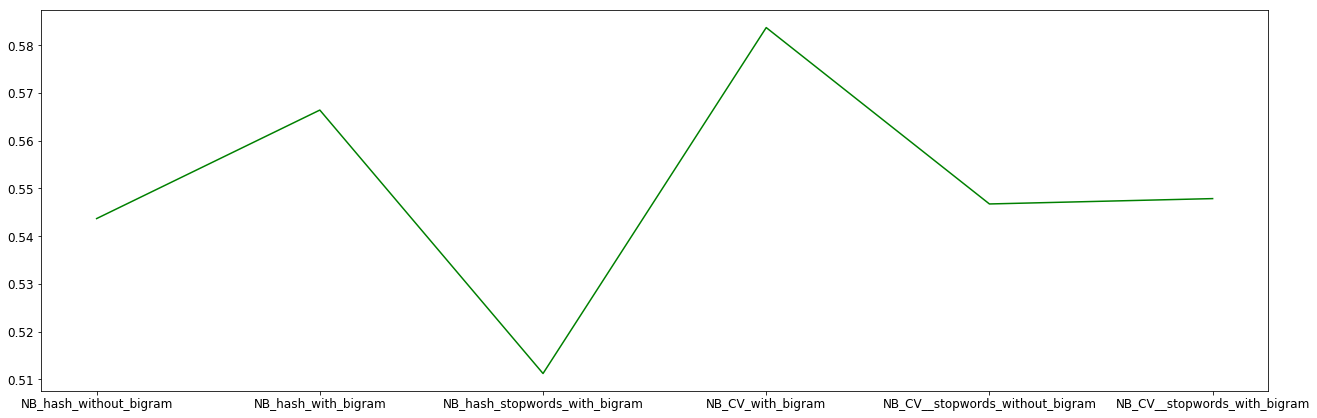

In [108]:
plt.show()

Best is Count vectorizer with bigram and all the features